In [1]:
import sys 
sys.path.append('/Users/tousif/LightHART/')


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn.functional as F
from utils.dataprocessing import sf_processing, normalization


In [3]:
'''
Configuration
'''
train_subjects = [29,31, 32, 34, 35, 36, 37, 40, 41, 42, 43]
test_subjects = [ 44, 45, 46]
batch_size = 8
config = {
    'num_heads' : 2,
    'num_layers' : 2,
    'norm_first' : True,
    'embed_dim': 128,
    'activation': 'relu',
    'input_dim': 3,
    'num_classes': 9,
    'acc_frames' : 128,
    'mocap_frames' : 128
}


In [4]:
'''
Dataset Preparation
'''
from utils.dataprocessing import sf_processing, normalization

dataset = sf_processing(data_dir = '/Users/tousif/LightHART/data/smartfallmm',
                        subjects = test_subjects,
                        acc_window_size=config['acc_frames'],
                        skl_window_size=config['mocap_frames'],
                        num_windows=20)
norm_data, acc_scaler, skl_scaler =  normalization(data=dataset, mode = 'fit')

file paths 594


In [5]:

device = ('cuda:3' if torch.cuda.is_available() else 'cpu')
model = torch.load('/Users/tousif/LightHART/exps/smartfall_fall/student/ttfstudent.pth')
model.to(device)


TransModel(
  (input_proj): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
    (2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=32, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (encoder): TransformerEncoderWAttention(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (o

In [6]:
from Feeder.Make_Dataset import UTD_mm
from torch.utils.data import DataLoader

In [7]:
def plot_attention_map(attention_weights, layer_idx, input_idx):
    attn = attention_weights[layer_idx][input_idx, :, :].detach().cpu().numpy()
    sns.heatmap(attn, cmap='viridis')
    plt.title(f'Attention Map - Layer {layer_idx + 1}')
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')

In [8]:


def plot_input(inputs, fig_axs, labels):
    batch_size, num_steps, _ = inputs.shape
    time_steps = np.linspace(0, num_steps, num_steps)

# Plot inputs in the first row
    for i in range(batch_size):
        fig_axs[0, i].plot(time_steps, inputs[i], color='blue')
        fig_axs[0, i].set_title(f'Label {labels[i]+1}')
        fig_axs[0, i].set_xlabel('Time')
        fig_axs[0, i].set_ylabel('Value')
        fig_axs[0, i].grid(True)

# Plot the class distribution in the second row (bar plot for each time series)
def plot_output(outputs, fig_axs):
    batch_size, num_classes = outputs.shape
    for i in range(batch_size):
        fig_axs[1, i].bar(range(1, num_classes+1), outputs[i].detach().cpu().numpy(), color='red')
        fig_axs[1, i].set_title(f'Class Distribution {i+1}')
        fig_axs[1, i].set_xlabel('Class')
        fig_axs[1, i].set_ylabel('Probability')
        fig_axs[1, i].set_ylim(0, 1)  # Probabilities are between 0 and 1
        fig_axs[1, i].grid(True)

def plot_attention_map(fig_axs, attention_weights):
    batch_size, _ , _ = attention_weights[0].shape
    for i in range(batch_size) :
        attn = attention_weights[0][i, :, :].detach().cpu().numpy()
        sns.heatmap(attn, cmap='viridis', ax = fig_axs[2,i])
        #fig_axs[2,i].title(f'Attention Map - Layer {0 + 1}')
        fig_axs[2,i].set_xlabel('Key Positions')
        fig_axs[2,i].set_ylabel('Query Positions')
    

In [9]:
feeder = UTD_mm(dataset= norm_data, batch_size=batch_size)
loader = DataLoader(dataset=feeder, batch_size=batch_size)
for batch_idx, (inputs, targets, idx) in enumerate(loader):
    acc_data = inputs['acc_data']
    skl_data = inputs['skl_data']
    labels = targets
    output = model(acc_data, skl_data)
    output = F.softmax(output, dim = -1)
    layer_name = 'encoder'
    encoder_layer = getattr(model, layer_name)
    if batch_idx == 3:
        fig, axs = plt.subplots(3, batch_size, figsize=(36, 12))
        plot_attention_map(fig_axs=axs , attention_weights=encoder_layer.attention_weights)
        plot_input(inputs=acc_data,fig_axs=axs, labels=labels)
        plot_output(outputs=output, fig_axs=axs)
        plt.tight_layout()
        plt.savefig('/Users/tousif/LightHART/exps/smartfall_har/student/with_smv_to_embedding/map_output_after_fix.png')
        

        

RuntimeError: expected scalar type Double but found Float

### Butterworth Filter

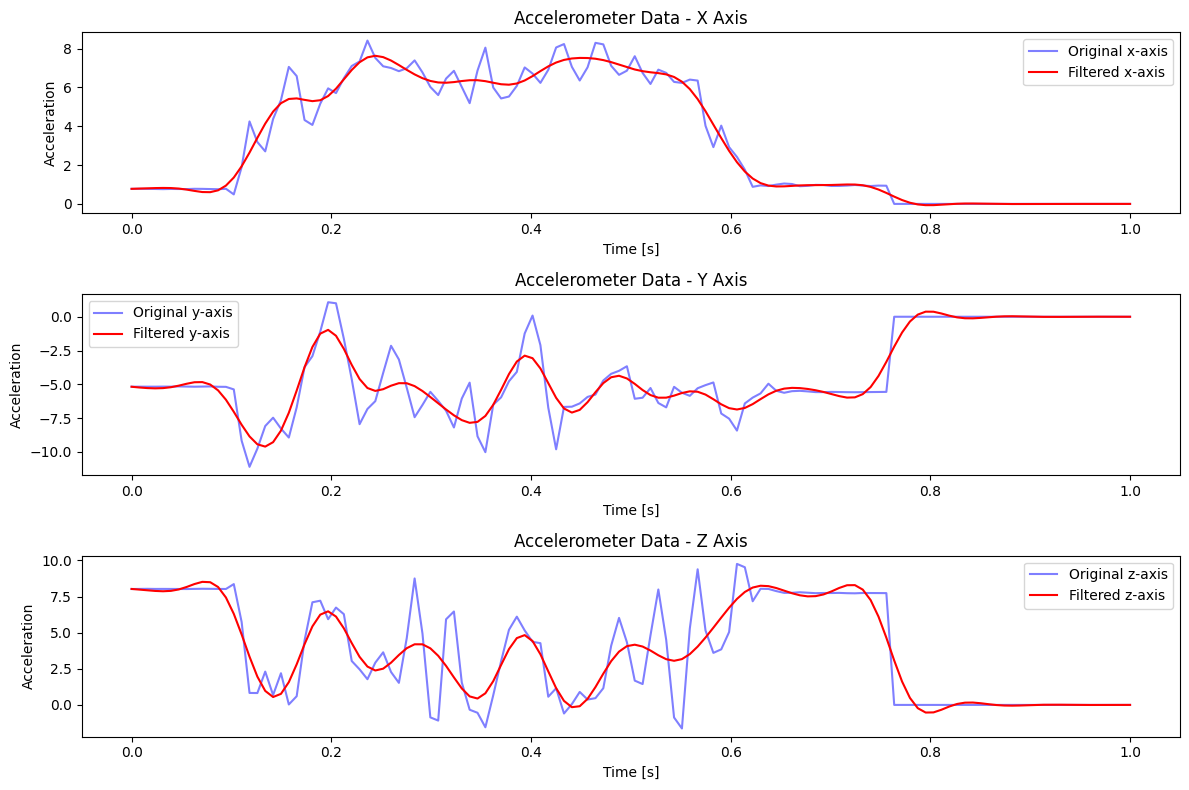

In [20]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Example multivariate accelerometer data (replace this with your actual data)
time = np.linspace(0, 1, 128)  # Time vector
# Simulated accelerometer data for 3 axes (x, y, z)
accelerometer_data = dataset['acc_data'][1]

# Butterworth filter design function
def butterworth_filter(data, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff frequency
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data, axis=0)  # Apply filter across the axis (0 for multivariate data)

# Parameters for the filter
cutoff_frequency = 1.0  # Desired cutoff frequency in Hz
sampling_frequency = 10  # Sampling rate in Hz
order = 4  # Filter order

# Apply Butterworth filter to each axis (multivariate data)
filtered_accel_data = butterworth_filter(accelerometer_data, cutoff_frequency, sampling_frequency, order)

# Plot original and filtered data for each axis
plt.figure(figsize=(12, 8))
for i, axis_label in enumerate(['x', 'y', 'z']):
    plt.subplot(3, 1, i + 1)
    plt.plot(time, accelerometer_data[:, i], label=f'Original {axis_label}-axis', color='blue', alpha=0.5)
    plt.plot(time, filtered_accel_data[:, i], label=f'Filtered {axis_label}-axis', color='red')
    plt.title(f'Accelerometer Data - {axis_label.upper()} Axis')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration')
    plt.legend()

plt.tight_layout()
plt.show()


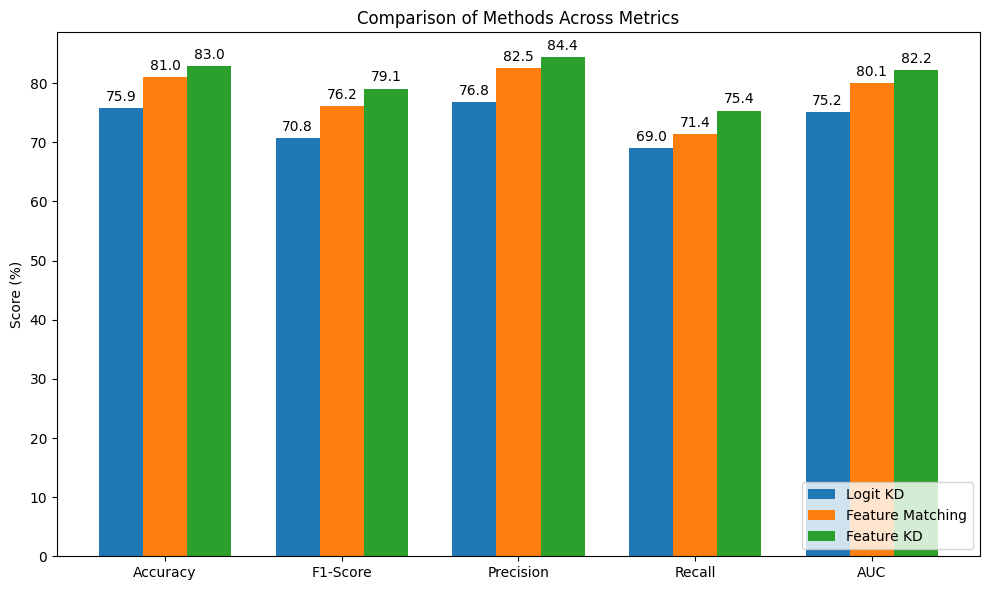

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Data
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC']
logit_kd = [75.86, 70.75, 76.76, 68.99, 75.17]
feature_matching = [80.98, 76.19, 82.51, 71.44, 80.08]
feature_kd = [82.96, 79.10, 84.38, 75.37, 82.18]

# X-axis positions
x = np.arange(len(metrics))
width = 0.25  # Width of the bars

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, logit_kd, width, label='Logit KD')
rects2 = ax.bar(x, feature_matching, width, label='Feature Matching')
rects3 = ax.bar(x + width, feature_kd, width, label='Feature KD')

# Labels and Title
ax.set_ylabel('Score (%)')
ax.set_title('Comparison of Methods Across Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc ='lower right')

# Adding bar labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.show()